In [3]:
import pandas as pd

data_path = "C:\\Users\\coher\\Desktop\\Silicon tests\\SHT1_Twente\\N43_2024-04-26\\2024-04-26_12-09-40.csv"
df = pd.read_csv(data_path)

RB (V) LB (V)
New measurement 2 (V)


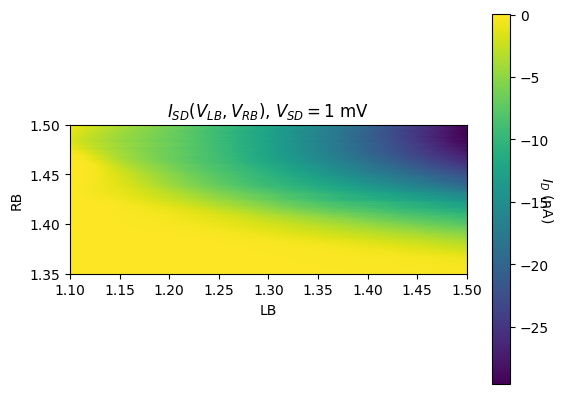

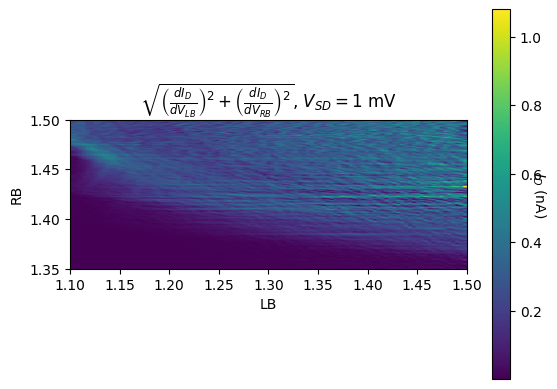

In [50]:
X, Y = df.columns[1:3]
print(X, Y)
Z = df.columns[4]
print(Z)
raw_numpy_data = df.pivot_table(values=Z, index=[X], columns=[Y]) * 1e-7 / 1e-9
Xdata, Ydata = raw_numpy_data.columns, raw_numpy_data.index

import matplotlib.pyplot as plt
import numpy as np

h_grad = np.gradient(raw_numpy_data, axis=0)
v_grad = np.gradient(raw_numpy_data, axis=1)

# import scipy as sp
# raw_numpy_data =sp.ndimage.filters.gaussian_filter(raw_numpy_data, 1., mode='constant')

plt.imshow(
    raw_numpy_data,
    extent=[Xdata[0], Xdata[-1], Ydata[0], Ydata[-1]],
    origin='lower'
)
plt.title(r"$I_{SD}(V_{LB}, V_{RB})$, $V_{SD}=1$ mV")
cbar = plt.colorbar()
cbar.set_label(r'$I_{D}$ (nA)', rotation=270)
plt.xlabel("LB")
plt.ylabel("RB")
plt.show()
plt.imshow(
    np.sqrt(h_grad**2 + v_grad**2),
    extent=[Xdata[0], Xdata[-1], Ydata[0], Ydata[-1]],
    origin='lower'
)
plt.title(r"$\sqrt{\left(\frac{dI_{D}}{dV_{LB}}\right)^2 + \left(\frac{dI_{D}}{dV_{RB}}\right)^2}$, $V_{SD}=1$ mV")
cbar = plt.colorbar()
cbar.set_label(r'$I_{D}$ (nA)', rotation=270)
plt.xlabel("LB")
plt.ylabel("RB")
plt.show()
# raw_numpy_data = raw_numpy_data.values

In [1]:
import numpy as np
import scipy 
import qcodes as qc
import matplotlib.pyplot as plt
import os
import datetime

## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    TogetherSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)

## Using interactive widget
from qcodes.interactive_widget import experiments_widget

## Dummy instruments for generating synthetic data
from qcodes.tests.instrument_mocks import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)


In [2]:
import numpy as np
import qcodes as qc
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter

def exp_fit(x, a, b, x0, y0):
    return a * np.exp(b * (x - x0)) + y0

def sigmoid_fit(x, a, b, x0, y0):
    return a/(1+np.exp(b * (x-x0))) + y0

class DummySemiconductor(Instrument):
    def __init__(self, name, noise_level=2 * 1e-14, setter_instr=None,**kwargs):
        super().__init__(name, **kwargs)
        
        # Define parameters
        self.add_parameter('v1_turn_on',
                           label='Voltage',
                           unit='V',
                           get_cmd=self._get_voltage_turn_on)
        # Define parameters
        self.add_parameter('v1_pinch_off',
                           label='Voltage',
                           unit='V',
                           get_cmd=self._get_voltage_pinch_off)

        self.multiplier = 2 # affects max current
        self.a = self.multiplier *np.random.normal(-1.2e-12,0.01*1.2e-12, 1)
        self.b = np.random.normal(-5,0.01*5, 1)
        self.x0 = np.random.normal(0.2,0.01*0.2, 1)
        self.y0 = self.multiplier * np.random.normal(1.5e-12,0.01*1.5e-12, 1)

        self.c = self.multiplier *np.random.normal(-1e-12,0.01*1e-12, 1)
        self.d = self.multiplier * np.random.normal(1e2,0.01*1e2, 1)
        self.x1 = np.random.normal(self.x0,0.01*self.x0, 1)
        self.y1 = self.multiplier * np.random.normal(1e-12,0.01*1e-12, 1)

        self.noise_level = noise_level
        self.setter_instr = setter_instr  # Placeholder for the setter instrument
    
    def _get_voltage_turn_on(self):
        if self.setter_instr is None:
            raise ValueError("The 'setter_instr' has not been set.")
        
        # Get the value set on the setter instrument
        ch1_value = self.setter_instr.ch1.get_latest() 
        
        # Calculate exponential fit
        result = max(0, exp_fit(ch1_value, self.a, self.b, self.x0, self.y0)) + self.noise_level * np.random.randn()
    
        return result
    
    def _get_voltage_pinch_off(self):
        if self.setter_instr is None:
            raise ValueError("The 'setter_instr' has not been set.")
        
        # Get the value set on the setter instrument
        ch1_value = self.setter_instr.ch1.get_latest() 

        # Calculate exponential fit
        result = sigmoid_fit(ch1_value,self.c,self.d,self.x1,self.y1) + self.noise_level * np.random.randn()

        return result

    def ask(self, cmd):
        # Define a basic ask method that returns a fixed response
        if cmd.strip() == '*IDN?':
            return 'DummySemiconductor,Virtual Instrument,1.0'
        else:
            raise NotImplementedError(f"Command '{cmd}' is not implemented.")


In [3]:
device_gates = ['S','STL','LB','P','RB','STR']
# A dummy signal generator with two parameters ch1 and ch2
sim900 = DummyInstrument('sim900', gates=['ch1', 'ch2'])

# A dummy digital multimeter that generates a synthetic data depending
# on the values set on the setter_instr, in this case the dummy dac
# agilent = DummyInstrumentWithMeasurement('agilent', setter_instr=sim900)
# Instantiate the dummy semiconductor instrument
agilent = DummySemiconductor('agilent', setter_instr=sim900)
station = qc.Station(sim900, agilent)

In [4]:
# Initialize or create the database at the specified path
# Generate today's date in the format YYYY-MM-DD
today_date = datetime.date.today().strftime("%Y-%m-%d")
initialise_or_create_database_at(f"~/experiments_{today_date}.db")
print(qc.config.core.db_location)

~/experiments_2024-03-01.db


In [5]:
tutorial_exp = load_or_create_experiment("doNd_debug", sample_name="no sample")

In [6]:
experiments()

[doNd_debug#no sample#1@/Users/andrijapaurevic/experiments_2024-03-01.db
 -----------------------------------------------------------------------]

In [7]:
device_info = {}

Starting experimental run with id: 1. Using 'qcodes.dataset.dond'


An exception occurred in measurement with guid: c970c66f-0000-0000-0000-018dfab7b2af;
Traceback:
Traceback (most recent call last):
  File "/Users/andrijapaurevic/opt/anaconda3/envs/opt_control/lib/python3.10/site-packages/qcodes/dataset/dond/do_nd.py", line 754, in dond
    raise BreakConditionInterrupt("Break condition was met.")
qcodes.dataset.dond.do_nd_utils.BreakConditionInterrupt: Break condition was met.

Measurement has been interrupted, data may be incomplete: Break condition was met.


Turn on:  0.154 V
Saturation Voltage:  0.37 V
Global Turn On Distance:  0.216 V


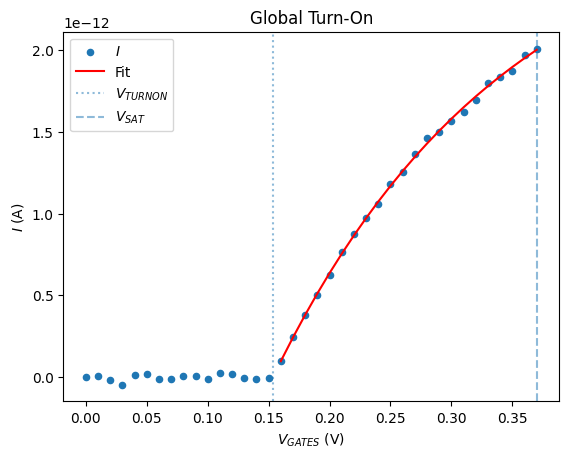

In [8]:
max_V = 1
N = 101

min_current = 0.05 * 1e-12
max_current = 2e-12

sweep_ch1 = LinSweep(sim900.ch1, 0, max_V, N, 0.01, get_after_set=True)
sweep_ch2 = LinSweep(sim900.ch2, 0, max_V, N, 0.01, get_after_set=True)

gate_sweeps = [sweep_ch1, sweep_ch2]

def isSaturated():
    return agilent.v1_turn_on() > max_current

def fit_data():
    dataset = qc.load_last_experiment().last_data_set()
    df = dataset.to_pandas_dataframe().reset_index()

    df_current = df.copy()
    df_current = df_current.rename(columns={'agilent_v1_turn_on': 'agilent_current'})
    df_current.iloc[:,-1] = df_current.iloc[:,-1].mul(1).subtract(0) # sensitivity

    axes = df_current.plot.scatter(y='agilent_current', x='sim900_ch1', linewidth=1, s=20, label=r'$I$')
    axes.set_ylabel(r'$I$ (A)')
    axes.set_xlabel(r'$V_{GATES}$ (V)')
    axes.set_title('Global Turn-On')

    mask = df_current['agilent_current'] > min_current # arbitrary current value, change if needed
    X_thres = df_current['sim900_ch1'][mask]
    Y_thres = df_current['agilent_current'][mask]
    guess = (-max(Y_thres), -1, min(X_thres), max(Y_thres))
    
    fit_params, fit_cov = scipy.optimize.curve_fit(exp_fit, X_thres, Y_thres, guess)
    a, b, x0, y0 = fit_params

    plt.plot(X_thres, exp_fit(X_thres, a,b,x0,y0), 'r-', label='Fit')

    V_turn_on =  round(np.log(-y0/a)/b + x0,3)
    V_sat = df_current['sim900_ch1'].iloc[-1]
    print("Turn on: ", V_turn_on, "V")
    print("Saturation Voltage: ", V_sat, "V")
    axes.axvline(x=V_turn_on, alpha=0.5, linestyle=':',label=r'$V_{TURNON}$')
    axes.axvline(x=V_sat,alpha=0.5, linestyle='--',label=r'$V_{SAT}$')

    plt.legend(loc='best')
    print("Global Turn On Distance: ", V_sat - V_turn_on, "V")

    device_info['Turn On'] = V_turn_on
    device_info['Saturation'] = V_sat
    device_info['Turn On Distance'] = V_sat - V_turn_on

result = dond(
    TogetherSweep(
        *gate_sweeps
    ), 
    agilent.v1_turn_on, 
    # show_progress=True, 
    # use_threads=False,
    break_condition=isSaturated,
    exit_actions=[fit_data],
    exp=tutorial_exp,
    measurement_name='Global Turn On',
) # Return A tuple of QCoDeS DataSet, Matplotlib axis, Matplotlib colorbar.


In [9]:
sim900.print_readable_snapshot()
print(device_info)

sim900:
	parameter value
--------------------------------------------------------------------------------
IDN :	{'vendor': 'QCoDeS', 'model': "<class 'qcodes.instrument_drivers.mock_i...
ch1 :	0.37 (V)
ch2 :	0.37 (V)
{'Turn On': 0.154, 'Saturation': 0.37, 'Turn On Distance': 0.216}


Pinching off ch1
Starting experimental run with id: 6. Using 'qcodes.dataset.dond'


An exception occurred in measurement with guid: 83e02830-0000-0000-0000-018dfaba03b0;
Traceback:
Traceback (most recent call last):
  File "/Users/andrijapaurevic/opt/anaconda3/envs/opt_control/lib/python3.10/site-packages/qcodes/dataset/dond/do_nd.py", line 754, in dond
    raise BreakConditionInterrupt("Break condition was met.")
qcodes.dataset.dond.do_nd_utils.BreakConditionInterrupt: Break condition was met.

Measurement has been interrupted, data may be incomplete: Break condition was met.


sim900_ch1
Fit function: sigmoid_fit
Width of sigmoid: 0.029 mV


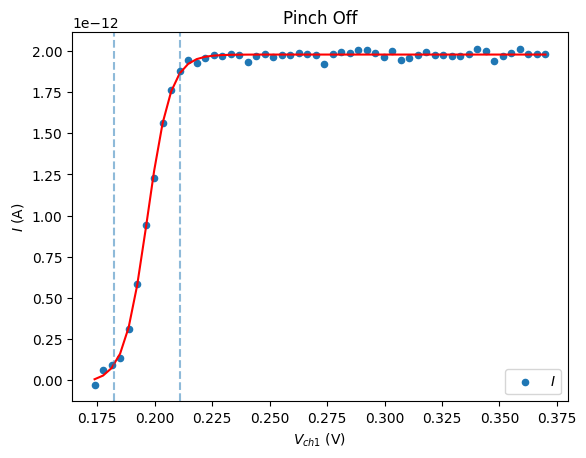

In [13]:

N = 101
sweep_ch1 = LinSweep(station.sim900.ch1, device_info['Saturation'], 0, N, 0.01, get_after_set=True)
sweep_ch2 = LinSweep(station.sim900.ch2, device_info['Saturation'], 0, N, 0.01, get_after_set=True)

min_current_val = 0.1 * 1e-14

gate_sweeps = [
    sweep_ch1,
    # sweep_ch2
]

def fit_data():

    dataset = qc.load_last_experiment().last_data_set()
    df = dataset.to_pandas_dataframe().reset_index()

    df_current = df.copy()
    df_current = df_current.rename(columns={'agilent_v1_pinch_off': 'agilent_current'})
    df_current.iloc[:,-1] = df_current.iloc[:,-1].mul(1).subtract(0) # sensitivity

    axes = df_current.plot.scatter(y='agilent_current', x='sim900_ch1', linewidth=1, s=20, label=r'$I$')

    axes.set_ylabel(r'$I$ (A)')
    axes.set_xlabel(r'$V_{{{gate}}}$ (V)'.format(gate=str(sweep._param).split('_')[-1]))
    axes.set_title('Pinch Off')

    X = df_current['sim900_ch1']
    Y = df_current['agilent_current']

    guess = (-2e-12,100,device_info['Turn On'],2e-12)
    
    fit_params, fit_cov = scipy.optimize.curve_fit(sigmoid_fit, X, Y, guess)
    a, b, x0, y0 = fit_params

    plt.plot(X, sigmoid_fit(X, a,b,x0,y0), 'r-', label='Fit')

    print(f"Fit function: {sigmoid_fit.__name__}")
    print(f"Width of sigmoid: {round(2 * np.sqrt(8) / b,3)} mV")
    axes.axvline(x=x0 - np.sqrt(8) / b, alpha=0.5, linestyle='--')
    axes.axvline(x=x0 + np.sqrt(8) / b,alpha=0.5, linestyle='--')

def min_current():
    return agilent.v1_pinch_off() < min_current_val
    
for sweep in (gate_sweeps):
    print(f"Pinching off {str(sweep._param).split('_')[-1]}")
    result = dond(
        sweep,
        agilent.v1_pinch_off, 
        break_condition=min_current,
        exit_actions=[fit_data],
        measurement_name='{} Pinch Off'.format(str(sweep._param).split('_')[-1]),
        exp=tutorial_exp
    )
    